<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/PlotFormantsWithParselmouth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Parselmouth library to run praat scripts with python

In [504]:
#!pip install -U praat-parselmouth

In [505]:
import parselmouth 
from parselmouth import praat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [506]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this noteboo

Define functions

In [507]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

In [508]:
def draw_formant(formant_series,times, text):
    # Convert formant (series) to numpy array and
    # replace unvoiced samples by NaN to not plot
    formant_values = np.array(formant_series)
    formant_values[formant_values==0] = np.nan
    plt.plot(times, formant_values, 'o', markersize=5, color='w')
    plt.plot(times, formant_values, 'o', markersize=2, color=np.random.rand(3,))
    plt.grid(False)
    plt.ylim(0, math.ceil(np.nanmax(formant_values))+150)
    plt.ylabel(text)

In [509]:
def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

Select Input

In [510]:
testfile = '/content/PD_OFF_TesiPDL_VowelE_0018_FineCut_LowCut12kHz.wav'

Import Audio 

In [511]:
snd = parselmouth.Sound(testfile) 

Extract F0 from audio data

In [512]:
f0min=75
f0max=300
pointProcess = praat.call(snd, "To PointProcess (periodic, cc)", f0min, f0max)

Extract the formants

In [513]:
formNum = 5
formants = praat.call(snd, "To Formant (burg)", 0.0025, formNum, 5000, 0.025, 50)

Assign formant values with times where they make sense (periodic instances)

In [514]:
numPoints = praat.call(pointProcess, "Get number of points")
f1_list = []
f2_list = []
f3_list = []
f4_list = []
f5_list = []
times = []
# Extract 5 formants (F1,...,F5)
for point in range(0, numPoints):
    point += 1
    t = praat.call(pointProcess, "Get time from index", point)
    times.append(t)
    f1 = praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
    f2 = praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
    f3 = praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
    f4 = praat.call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
    f5 = praat.call(formants, "Get value at time", 5, t, 'Hertz', 'Linear')
    
    f1_list.append(f1)
    f2_list.append(f2)
    f3_list.append(f3)
    f4_list.append(f4)
    f5_list.append(f5)

formants_all = []
# Create List of lists
formants_all.append(f1_list)
formants_all.append(f2_list)
formants_all.append(f3_list)
formants_all.append(f4_list)
formants_all.append(f5_list)

# Create formant dataframe
df = pd.DataFrame(formants_all)
# transpose of dataframe
df = df.transpose()
df.columns = ['F1','F2','F3','F4','F5']
df.describe()

,F1,F2,F3,F4,F5
count,982.000000,982.000000,982.000000,982.000000,460.000000
mean,353.414983,1521.582988,2452.037190,4206.307968,4387.261351
std,11.916731,73.155581,105.801554,172.482320,97.452556
min,299.204792,1367.864561,1639.923257,3465.498123,4187.670487
25%,345.407004,1464.653690,2437.726631,4094.141675,4332.777305
50%,353.161162,1515.141725,2470.147892,4279.446313,4370.985715
75%,361.412008,1577.666231,2494.957469,4334.794094,4410.129936
max,388.245155,1681.547943,3423.881783,4472.889684,4889.368535


Extract and plot F0 over the spectrogram

In [515]:
pitch = snd.to_pitch()
spectrogram = snd.to_spectrogram()

If desired, pre-emphasize the sound fragment before calculating the spectrogram


In [516]:
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

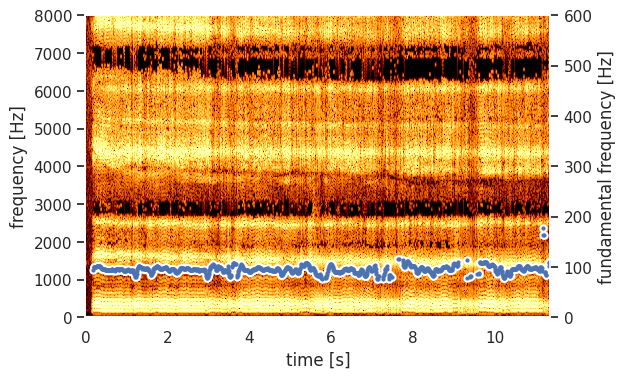

In [517]:
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

Plot Intensity (dB)

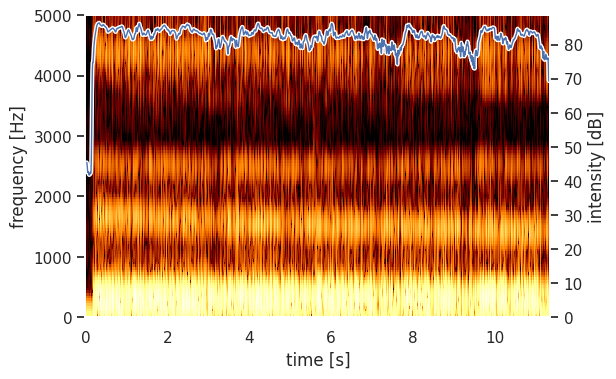

In [518]:
intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

Plot Formants

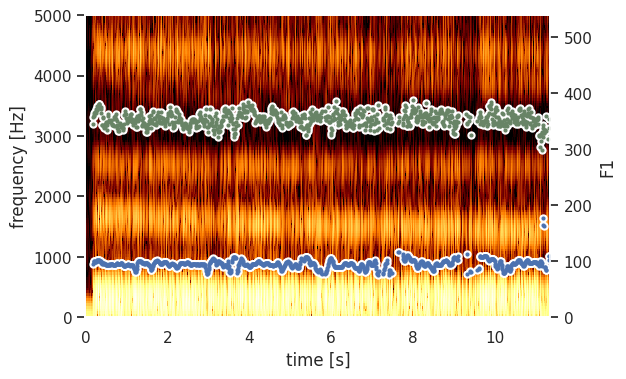

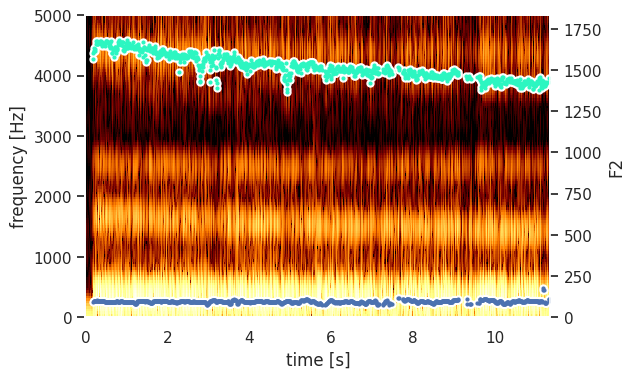

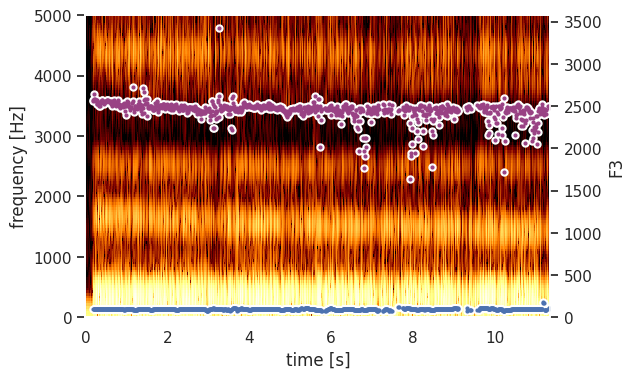

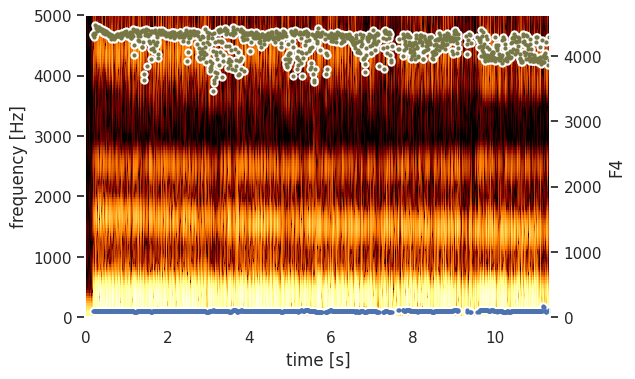

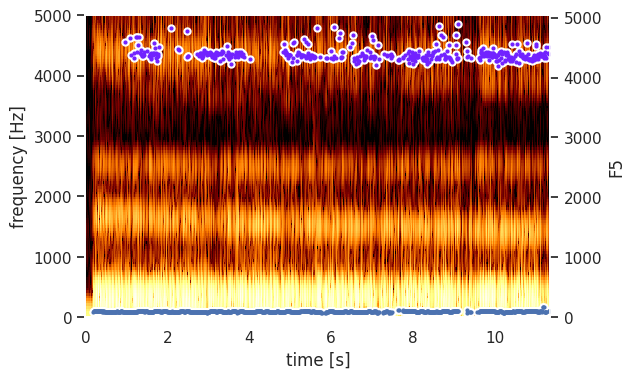

In [519]:
names = df.columns
for i in range(0,df.shape[1]):
  plt.figure()
  draw_spectrogram(spectrogram)
  plt.twinx()
  draw_pitch(pitch)
  plt.xlim([snd.xmin, snd.xmax])
  Fi = df.iloc[:, i]
  draw_formant(Fi, times, names[i])
  plt.show()